# Day 18

## Part 1

- count the surface area of a lava droplet
- the droplet is defined by a series of 1x1x1 cubes
- the surface area is any face not immeidately connected to another cube

`What is the surface area of your scanned lava droplet?`

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
from utils import parse_from_file, ParseConfig

parser = ParseConfig('\n', ParseConfig(',', int))

cubes = parse_from_file('day_18.txt', parser)

print(cubes[:10])

[[3, 10, 12], [7, 19, 11], [19, 8, 12], [18, 17, 8], [14, 13, 5], [11, 12, 20], [20, 11, 13], [5, 9, 18], [13, 2, 11], [15, 11, 3]]


In [2]:
def get_surface_area(cubes: list[list[int]]) -> int:
    """
    returns the surface area of all cubes listed
    """
    surface_area = 6 * len(cubes)

    for cube in cubes:
        for other_cube in cubes:
            if cube == other_cube:
                continue
            for index, (a, b) in enumerate(zip(cube, other_cube)):
                if all(
                    [
                        c == d for i, (c, d) in enumerate(zip(cube, other_cube))
                        if i != index
                    ]) and abs(a - b) <= 1:
                    surface_area -= 1
    return surface_area

test_cubes = [
    [1,1,1],
    [2,1,1],
    [4,1,1]
]

print(get_surface_area(test_cubes))

16


In [3]:
total_surface_area = get_surface_area(cubes)

print(f'the total surface area of the lava droplet is: {total_surface_area}!')

the total surface area of the lava droplet is: 4450!


## Part 2

- Instead find only the surface properly on the exterior of the droplet

(20, 21, 21)


Text(0.5, 0.98, 'how lavaley')

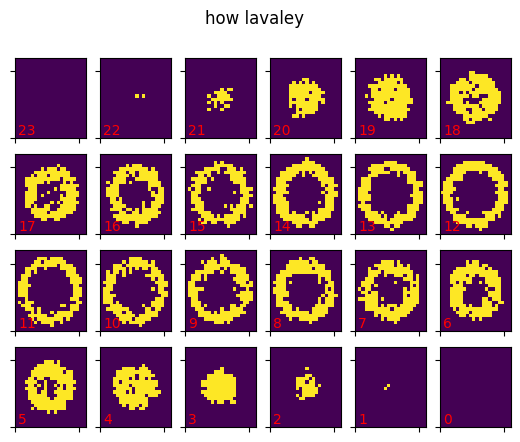

In [8]:
limits = (
    max([x for x, y, z in cubes]),
    max([y for x, y, z in cubes]),
    max([z for x, y, z in cubes])
)

print(limits)

grid = []
xlim, ylim, zlim = limits
for _ in range(zlim + 2):
    grid.append([])
    for __ in range(ylim + 3):
        grid[-1].append([])
        for ___ in range(xlim + 2):
            grid[-1][-1].append(0)

for x, y, z in cubes:
    grid[z][y + 1][x] = 1

# add a little extra padding
grid = [[[0 for _ in row] for row in grid[0]]] + grid

def plot_slices(grid: list[list[list[int]]], above_to_nan: int = None) -> None:
    """
    plots a series of 2d grid colour meshes for each z slice of a 3d grid
    """
    copy = deepcopy(grid)
    if above_to_nan is not None:
        for z, z_slice in enumerate(grid):
            for y, row in enumerate(z_slice):
                for x, value in enumerate(row):
                    if value >= above_to_nan:
                        copy[z][y][x] = np.nan
    nrows, ncols = 4, 6
    fig, _ = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False)
    for z_level, (ax, z_slice) in enumerate(zip(reversed(fig.axes), copy)):
        ax.pcolormesh(z_slice)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(1, 1, z_level, color='r')
    
    return fig

fig = plot_slices(grid)
fig.suptitle('how lavaley')

In [9]:
# let's create a net of all the positive and negative spaces
net = {}

for z, z_slice in enumerate(grid):
    for y, row in enumerate(z_slice):
        for x, value in enumerate(row):
            neighbours = []
            for ox, oy, oz in ((0, 0, 1), (0, 1, 0), (1, 0, 0), (0, 0, -1), (0, -1, 0), (-1, 0, 0)):
                # bounds check
                if not 0 <= x + ox < len(row):
                    continue
                if not 0 <= y + oy < len(z_slice):
                    continue
                if not 0 <= z + oz < len(grid):
                    continue
                if grid[z + oz][y + oy][x + ox] == value:
                    neighbours.append((x + ox, y + oy, z + oz))
            net.update({(x, y, z): neighbours})

print(list(net.items())[:1])

[((0, 0, 0), [(0, 0, 1), (0, 1, 0), (1, 0, 0)])]


In [13]:
# using Dijkstra's algorithm from day 12 with a few tweaks
def dijkstra(
        grid: list[list[list[int]]], net: dict, start: tuple[tuple[int]],
        end: 'tuple[tuple[int]]|None'
) -> 'list[list[int]]':
    """
    run Djikstra's algorithm to find the shortest distance from start to end
    """
    # mark all nodes as unvisited
    visited = [[[False for _ in row] for row in z_slice] for z_slice in grid]

    # set all notes to a tentative max distance from start
    max_distance = len(grid) * len(grid[0]) * len(grid[0][0])
    distances = [
        [[max_distance for _ in row] for row in z_slice] for z_slice in grid
    ]
    # ...except for our starting node which is 0s
    x, y, z = start
    distances[z][y][x] = 0

    # set current node as the start
    current_node = start

    number_visited = 0
    while True:
        x, y, z = current_node
        # iterate through each neighbour and set it's new tentative distance
        distance_to_here = distances[z][y][x]
        for neighbour in net[current_node]:
            x, y, z = neighbour
            if visited[z][y][x]:
                continue
            distances[z][y][x] = min(distances[z][y][x], distance_to_here + 1)
        x, y, z = current_node
        # mark this node as visited
        visited[z][y][x] = True
        number_visited += 1

        # if this node is the end, we're done!
        if current_node == end:
            return distances
        if number_visited % 100 == 0:
            percent_done = 100 * number_visited / max_distance
            print(f'{current_node} - {percent_done:.1f}%' + ' '*10, end='\r')
        
        # otherwise find the node with the smallest tenative distance and
        # repeat
        ux, uy, uz = None, None, None
        lowest_unvisited = max_distance
        for z, z_slice in enumerate(visited):
            for y, row in enumerate(z_slice):
                for x, is_visited in enumerate(row):
                    if is_visited:
                        continue
                    if distances[z][y][x] < lowest_unvisited:
                        ux, uy, uz = x, y, z
                        lowest_unvisited = distances[z][y][x]
        if lowest_unvisited == max_distance:
            # if true all reachable points have been visited
            return distances
        current_node = (ux, uy, uz)

outer_distances = dijkstra(grid, net, (0, 0, 0), None)

Text(0.5, 0.98, "we've only just touched the surface")

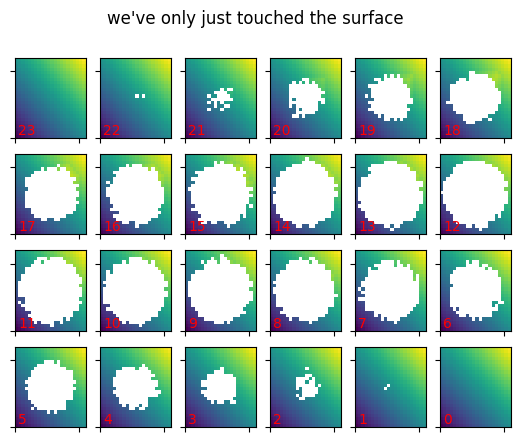

In [16]:
max_distance = len(grid) * len(grid[0]) * len(grid[0][0])
fig = plot_slices(outer_distances, above_to_nan = max_distance)
fig.suptitle('we\'ve only just touched the surface')

In [18]:
# let's re-create the inpt now but with a solid core
inner_cubes = []
for z, z_slice in enumerate(outer_distances):
    grid.append([])
    for y, row in enumerate(z_slice):
        grid[-1].append([])
        for x, distance in enumerate(row):
            if distance >= max_distance:
                inner_cubes.append((x, y, z))

print(inner_cubes[:10])

[(9, 11, 1), (10, 12, 1), (9, 8, 2), (10, 8, 2), (8, 9, 2), (10, 9, 2), (11, 9, 2), (12, 9, 2), (13, 9, 2), (10, 10, 2)]


In [19]:
exterior_surface_area = get_surface_area(inner_cubes)

In [20]:
print(f'the exterior suface area of the droplet is: {exterior_surface_area}!')

the exterior suface area of the droplet is: 2564!
